# Sep 13th, 2022 (Fig1: ROI plots, layer plots 10)

**Motivation**: ROIs, top, flat, coverage, etc.  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'paper2.0', 'ROI-figs')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

merge_thres = {
    128: 0.376,
    512: 0.444,
}
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/ROI-figs

## Prepare

In [3]:
nn = 512
num_k = 7
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc=15)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Top / flat

In [13]:
bs = Base(mice)
top, flat = bs.load_top_flat()
parc_top, parc_flat = mice.parcel.load_top_flat()
top, parc_top = filter_boundaries([top, parc_top], top > 0)
flat, parc_flat = filter_boundaries([flat, parc_flat], flat > 0)

In [28]:
regions = np.unique(parc_flat[parc_flat.nonzero()])
hcl = mice.parcel.decode(regions)
regions_l = mice.parcel.encode(hcl[hcl[:, 0] == 1])
regions_r = mice.parcel.encode(hcl[hcl[:, 0] == 2])

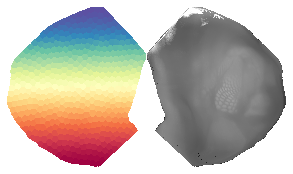

In [51]:
fig, ax = create_figure(1, 1, (5, 3))

ax.imshow(mwh(flat == 0, flat), cmap='Greys_r')
x2p = mwh(~np.isin(parc_flat, regions_l), parc_flat)
ax.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)

figname = f"parc_flat.png"
fig.savefig(pjoin(fig_dir, figname), **kws_fig)
plt.show()

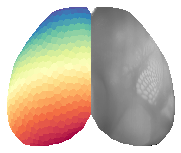

In [49]:
fig, ax = create_figure(1, 1, (3, 3))

ax.imshow(mwh(top == 0, top), cmap='Greys_r')
x2p = mwh(~np.isin(parc_top, regions_l), parc_top)
ax.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)

figname = f"parc_top.png"
fig.savefig(pjoin(fig_dir, figname), **kws_fig)
plt.show()

## Optical

In [4]:
from register.register import reset_ants_img
mice.setup_anat_data()

In [5]:
key = 'sub-SLC04_ses-3'

roi_2d = f"{key}_space-indiv2d_cols.nii.gz"
roi_2d = pjoin(mice.cfg.masks_dir, roi_2d)
roi_2d = ants.image_read(roi_2d, pixeltype='unsigned int')
roi_2d = reset_ants_img(
    img=roi_2d.numpy().squeeze(),
    spacing=roi_2d.spacing[:2],
    origin=0, use_um=False,
)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(
    img=ref.numpy().squeeze(),
    spacing=ref.spacing[:2],
    origin=0, use_um=False,
)
mask = mice.mask2d[key].load_ants('unsigned int')

roi_2d = ants.resample_image_to_target(
    image=roi_2d, target=mask,
    interp_type='genericLabel',
)
ref = ants.resample_image_to_target(
    image=ref, target=mask,
    interp_type='linear',
)
roi_2d *= mask
ref *= mask

mask = mask.numpy()
roi_2d = roi_2d.numpy()
ref = ref.numpy()

In [6]:
regions_here = roi_2d[roi_2d.nonzero()]
regions_here = np.unique(regions_here)
hcl = mice.parcel.decode(regions_here)
regions_here_r = regions_here[hcl[:, 0] == 2]

for r in regions_here:
    hh, cc, ll = mice.parcel.decode(r).ravel()
    if ll == 1:
        roi_2d[roi_2d == r] = mice.parcel.encode(f"{hh}-{cc}-0")
        
roi_tr, m_tr, ref_tr = filter_boundaries([roi_2d, mask, ref], mask)

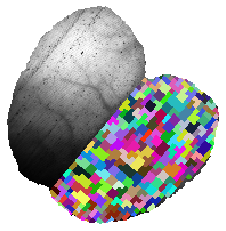

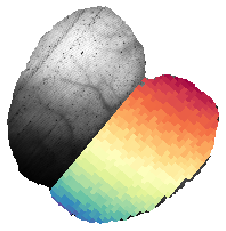

In [7]:
for cmap_name, cmap in {
    'random': get_rand_cmap(len(regions_here_r), get_rng(19)),
    'spectral': 'Spectral_r', }.items():
    fig, ax = create_figure(1, 1, (4, 4))

    plt.imshow(mwh(m_tr == 0, ref_tr), cmap='Greys_r', interpolation='none')
    plt.imshow(
        X=mwh(~np.isin(roi_tr, regions_here_r), roi_tr),
        cmap=cmap,
        interpolation='none',
        alpha=1.0,
    )
    remove_ticks(ax)

    figname = f"ROI-2d_{cmap_name}.png"
    fig.savefig(pjoin(fig_dir, figname), **kws_fig)
    plt.show()

In [8]:
key = 'sub-SLC04_ses-2'

In [9]:
roi_3d = f"{key}_space-indiv3d_cortex.nii.gz"
roi_3d = pjoin(mice.cfg.masks_dir, roi_3d)
roi_3d = ants.image_read(roi_3d, pixeltype='unsigned int')
roi_3d = roi_3d.numpy()

regions_included = roi_3d[roi_3d.nonzero()]
regions_included = np.unique(regions_included)
hcl = mice.parcel.decode(regions_included)
regions_included_surface = regions_included[hcl[:, 2] == 0]

len(regions_included), len(regions_included_surface)

(2766, 995)

In [10]:
roi_3d[~np.isin(roi_3d, regions_included_surface)] = 0

m3d = mice.mask3d[key].load_ants().numpy() 
t1w = mice.T1w[key].load_ants().numpy()

jj = 41

x2p = roi_3d[..., jj].T.copy()
x2p_rename = np.zeros(x2p.shape)

regions = np.unique(x2p[x2p.nonzero()])
for i, r in enumerate(regions):
    x2p_rename[x2p == r] = i + 1
_m3d = m3d[..., jj].T
_t1w = t1w[..., jj].T
_roi3d, _m3d, _t1w = filter_boundaries([x2p_rename, _m3d, _t1w], _m3d)

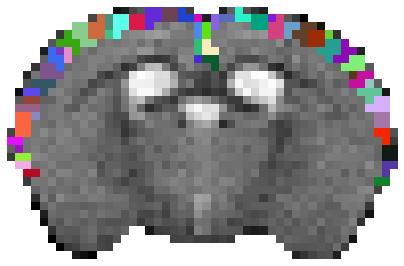

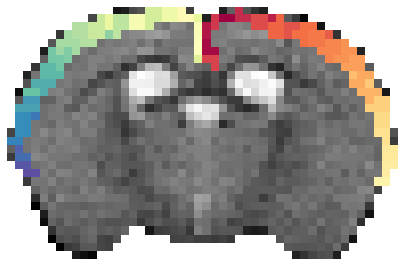

In [11]:
for cmap_name, cmap in {
    'random': get_rand_cmap(len(regions_here_r), get_rng(4)),
    'spectral': 'Spectral_r', }.items():

    fig, ax = create_figure(1, 1, (7, 5))
    ax.imshow(mwh(_m3d == 0, _t1w), cmap='Greys_r', interpolation='none')
    ax.imshow(mwh(_roi3d == 0, _roi3d), cmap=cmap, interpolation='none')
    remove_ticks(ax)

    figname = f"ROI-3d-coronal_{cmap_name}.png"
    # fig.savefig(pjoin(fig_dir, figname), **kws_fig)
    plt.show()

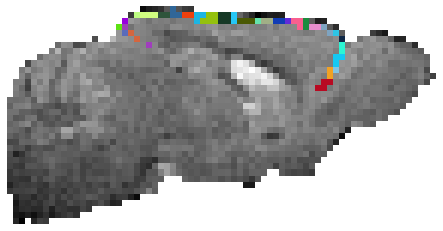

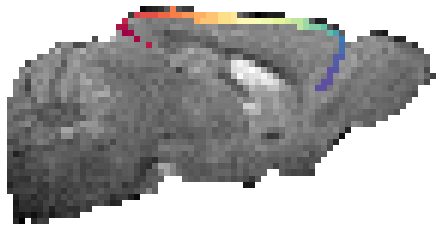

In [12]:
jj = 26

_roi3d, _m3d, _t1w = filter_boundaries([roi_3d[jj], m3d[jj], t1w[jj]], m3d[jj])

for cmap_name, cmap in {
    'random': get_rand_cmap(len(regions_here_r), get_rng(4)),
    'spectral': 'Spectral_r', }.items():
    
    fig, ax = create_figure(1, 1, (8, 4))
    ax.imshow(mwh(_m3d == 0, _t1w), cmap='Greys_r', interpolation='none')
    x2p = mwh(~np.isin(_roi3d, regions_included_surface), _roi3d)
    ax.imshow(x2p, cmap=cmap, interpolation='none')
    remove_ticks(ax)

    figname = f"ROI-3d-sagittal_{cmap_name}.png"
    fig.savefig(pjoin(fig_dir, figname), **kws_fig)
    plt.show()

<matplotlib.image.AxesImage object at 0x7f4ee1068d30>

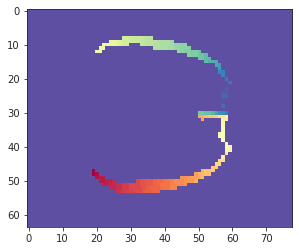

In [13]:
x2p = roi_3d[:, 13].copy()
x2p_rename = np.zeros(x2p.shape)

for i, r in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p_rename[x2p == r] = i + 1
plt.imshow(x2p_rename, cmap='Spectral_r')

In [14]:
from register.register import Register

In [15]:
reg = Register(mice)
reg.set_mode('ca2')
output = reg.get_accepted_regions()

Name: cortex . . . a total of: 542 regions accepted, 172 regions rejected.
accept ratio: 75.91 %, reject ratio: 24.09 %, using a presence threshold of 20.0 %

In [16]:
list(output)

['df', 'cortex', 'subcortex']

In [17]:
freq = output['cortex']['freq']

In [231]:
top, flat = gr_ca.load_top_flat()

# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

<matplotlib.image.AxesImage object at 0x7f200c95f460>

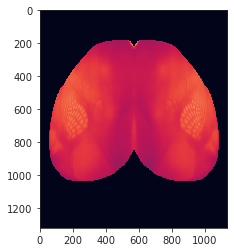

In [230]:
plt.imshow(top)

In [242]:
freq_ctx = np.zeros(top.shape, dtype=float)
for r, f in freq.items():
    m = parcel_top == r
    if not m.sum():
        continue
    freq_ctx[m] = f
    
freq_ctx *= 100

In [244]:
f_tr, t_tr = filter_boundaries([freq_ctx, top], top.astype(bool))

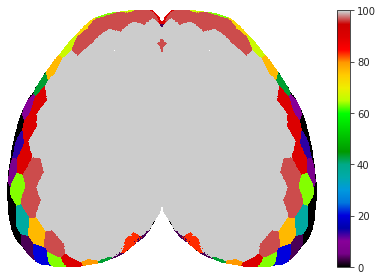

In [252]:
fig, ax = create_figure()

x2p = np.ma.masked_where(t_tr == 0, t_tr)
plt.imshow(x2p)

x2p = np.ma.masked_where(t_tr == 0, f_tr)
plt.imshow(x2p, cmap='nipy_spectral')
plt.colorbar()

remove_ticks(ax)

name = f'coverage-top'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

In [253]:
freq_ctx = np.zeros(flat.shape, dtype=float)
for r, f in freq.items():
    m = parcel_flat == r
    if not m.sum():
        continue
    freq_ctx[m] = f
freq_ctx *= 100

In [255]:
f_tr, t_tr = filter_boundaries([freq_ctx, flat], flat.astype(bool))

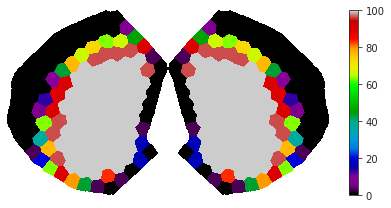

In [257]:
fig, ax = create_figure(figsize=(6, 3))

x2p = np.ma.masked_where(t_tr == 0, t_tr)
plt.imshow(x2p)

x2p = np.ma.masked_where(t_tr == 0, f_tr)
plt.imshow(x2p, cmap='nipy_spectral')
plt.colorbar()

remove_ticks(ax)

name = f'coverage-flat'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

## Layer plots

In [177]:
hemis = mice.al.make_hemis()
root = mice.al.get_masks('root')
template = mice.al.mcc.get_template_volume()[0]
layer_masks = mice.al.make_layer_masks()

lm = np.zeros(template.shape)
lm_shallow = np.zeros(template.shape)
for i, m in enumerate(layer_masks.values()):
    lm[m] = i + 1
    if i > 2:
        continue
    lm_shallow[m] = 1

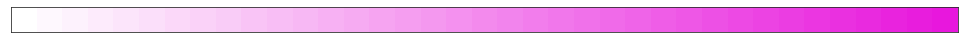

In [34]:
cmap = make_cmap(['#FFFFFF', '#e817dd'])

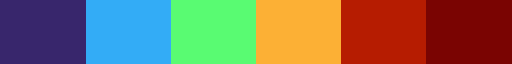

In [35]:
turbo = sns.color_palette('turbo', as_cmap=True)

colors = [0.03, 0.23, 0.42, 0.68, 0.92, 1.0]
colors = [turbo(i) for i in colors]
cmap_turbo = matplotlib.colors.ListedColormap(
    colors=colors, name='turbo')
cmap_turbo

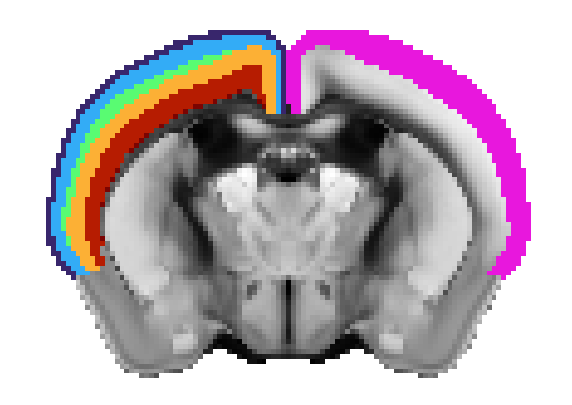

In [404]:
ii = 61

fig, ax = create_figure(1, 1, (10, 8))

x2p = template[ii]
x2p = mwh(root[ii] == 0, x2p)
ax.imshow(x2p, cmap='Greys_r')

x2p = lm[ii]
x2p = mwh(np.logical_or(x2p == 0, hemis[ii] == 2), x2p)
ax.imshow(x2p, cmap=cmap_turbo)

x2p = lm_shallow[ii]
x2p = mwh(np.logical_or(x2p == 0, hemis[ii] == 1), x2p)
ax.imshow(x2p, cmap=cmap, vmin=0, vmax=1)

remove_ticks(ax)

fig.savefig(pjoin(fig_dir, f'template.png'), **kws_fig)
plt.show()

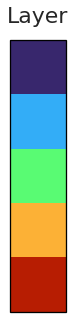

In [402]:
fig, cax, cbar = cbar_only(
    cmap=matplotlib.colors.ListedColormap(
        colors=colors[:-1][::-1], name='turbo'),
    edgecolor='k',
    tick_position='left',
    figsize=(1.0, 5.0),
)
cax.set_title('Layer', fontsize=22, y=1.04, rotation=0)
cax.yaxis.set_visible(False)

fig.savefig(pjoin(fig_dir, f'turbo.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'turbo.pdf'), **kws_fig)
fig

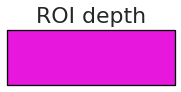

In [403]:
fig, cax, cbar = cbar_only(
    cmap=matplotlib.colors.ListedColormap(['#e817dd', '#e817dd']),
    edgecolor='k',
    tick_position='left',
    figsize=(3.0, 1.0),
)
cax.set_title('ROI depth', fontsize=22, y=1.04, rotation=0)
cax.yaxis.set_visible(False)

fig.savefig(pjoin(fig_dir, f'purp.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, f'purp.pdf'), **kws_fig)
fig

## Layer plots: $10\mu m$

In [24]:
from register.atlas import Allen

In [25]:
%%time

al10 = Allen(10)
hemis = al10.make_hemis()
root = al10.get_masks('root')
template = al10.mcc.get_template_volume()[0]

CPU times: user 15.5 s, sys: 9.87 s, total: 25.4 s
Wall time: 26.2 s


In [26]:
subtree, _ = al10.get_subtree(315, show=False)
layers = collections.defaultdict(list)
for node in subtree.leaves():
    tag = node.tag.split('(')[0].strip()
    for ll in ['1', '2/3', '4', '5', '6a', '6b']:
        if tag[-len(ll):] == ll:
            layers[ll].append(node.identifier)
layers = dict(sorted(layers.items()))

In [27]:
def fun(i):
    m = al10.mcc.get_structure_mask(i)[0]
    return np.where(m)

In [28]:
%%time

layer_masks = {}
for k, struct_ids in layers.items():
    with joblib.parallel_backend('multiprocessing'):
        results = joblib.Parallel(n_jobs=25)(
            joblib.delayed(fun)(i)
            for i in struct_ids
        )
    x, y, z = [], [], []
    for a, b, c in results:
        x.append(a)
        y.append(b)
        z.append(c)
    x = np.concatenate(x)   
    y = np.concatenate(y)
    z = np.concatenate(z)
    m = np.zeros(template.shape)
    m[x, y, z] = 1
    layer_masks[k] = m.astype(bool)
list(layer_masks)

CPU times: user 17.7 s, sys: 54.2 s, total: 1min 11s
Wall time: 13min 37s


['1', '2/3', '4', '5', '6a', '6b']

In [32]:
lm = np.zeros(template.shape)
lm_shallow = np.zeros(template.shape)
for i, m in enumerate(layer_masks.values()):
    lm[m] = i + 1
    if i > 2:
        continue
    lm_shallow[m] = 1

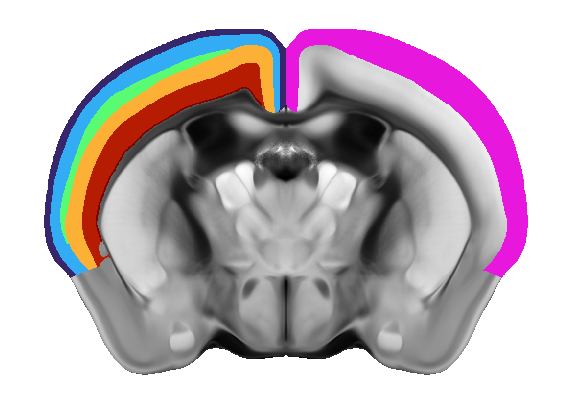

In [54]:
ii = 610

fig, ax = create_figure(1, 1, (10, 8))

x2p = template[ii]
x2p = mwh(root[ii] == 0, x2p)
ax.imshow(x2p, cmap='Greys_r')

x2p = lm[ii]
x2p = mwh(np.logical_or(x2p == 0, hemis[ii] == 2), x2p)
ax.imshow(x2p, cmap=cmap_turbo)

x2p = lm_shallow[ii]
x2p = mwh(np.logical_or(x2p == 0, hemis[ii] == 1), x2p)
ax.imshow(x2p, cmap=cmap, vmin=0, vmax=1)

remove_ticks(ax)

fig.savefig(pjoin(fig_dir, f'template10.png'), **kws_fig)
plt.show()